# Model performance evaluation
## Context and objectives
Since the start of this project, I had the chance to present it twice to industry experts. From both presentations I received a number of feedback points related to the performance of the system and its viability in a real-case scenario. In particular, the comments were related to the following points:
1. The dataset is heavily imbalanced (193 shooters against 1000 negatively classified individuals in the best case and 300M+ individuals in the US population)
2. Because the risk associated with a false negative and the ethics of a false positive, the precision and recall may be carefully balanced

Since then, I have also better understood different performance metrics such as the F1-score and the ROC Curve and AUC. I also want to spend more time on looking at the classification threshold.

## Methodology
In this notebook, I spend more time evaluating each of the models I have developped. I first start with the Logistic Regression which is recommended as a first model thanks to its balance of performance and interpretability.
### Preparation
For this model, the following steps are used for all iterations:
1. Import and split the data
2. Scale the data

### Hyperparameters to consider
I look at different parameters:
```python
    solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    max_iter = list(range(20,100))
    regularisations = np.linspace(.1, 2, 20)
    penalties = ['l1', 'l2', 'elsticnet']
```

### Metrics
- accuracy
- precision-recall curve
- f1 curve
- roc curve and auc

In [387]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Data and files manipulation
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

# Visualisation
from matplotlib import pyplot as plt
import seaborn as sns

# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import the modules to evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.metrics import roc_curve, auc

### Functions

In [222]:
def transform_gender_col(df):
    # Change gender column to male/other (male = yes, other = no)
    df.loc[df['Gender'] != 'Male', 'Gender'] = 'No'
    df.loc[df['Gender'] == 'Male', 'Gender'] = 'Yes'

    # Rename column from 'Gender' to 'Male'
    return df.rename(columns={'Gender': 'Male'})

def transform_autism_col(df):
    # Change autism column values to Yes and No
    df.loc[df['Autism'] != 'No evidence', 'Autism'] = 'Yes'
    df.loc[df['Autism'] == 'No evidence', 'Autism'] = 'No'
    return df

def transform_employed_col(df):
    # Change employed column values to Yes and No
    df.loc[df['Employed'] != 'Working', 'Employed'] = 'No'
    df.loc[df['Employed'] == 'Working', 'Employed'] = 'Yes'
    return df

In [209]:
def one_hot_encoding(df):
    # Get all the features with only two unique values in a list
    mask = df.nunique()==2
    feature_with_2_values = list(df.nunique()[mask].index)

    # Change all the 2-value features to binary columns (1 = 'Yes', 0 = 'No')
    for feat in feature_with_2_values:
        df[feat] = [1 if c=='Yes' else 0 for c in df[feat]]

    return df

In [210]:
def encode_categorical_features(df):
    categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
    numeric_features = list(df.dtypes[df.dtypes != 'object'].index)

    if len(categorical_features) > 0:
        # Get dummies for categorical features
        dummies_df = pd.get_dummies(df[categorical_features])

        # Recombine all features
        return pd.concat([df[numeric_features], dummies_df], axis=1)
    else:
        return df

In [245]:
def scale_data(X_train, X_test, scale):
    if scale:
        # Creating StandardScaler instance
        scaler = StandardScaler()

        # Fitting Standard Scaller
        X_scaler = scaler.fit(X_train)

        # Scaling data
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)
    
    return X_train, X_test


#### Functions for data visualisation

In [390]:
# Define plot parameters
main_color = '#969696'
highlight_color = '#04bfb3'
default_figsize = (10,6)

In [392]:
def show_confusion_matrix(matrix, title, save=False):
    fig, ax = plt.subplots()

    sns.heatmap(
        matrix,
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['0', '1'],
        yticklabels=['0', '1'],
        cmap=sns.color_palette(f"light:{highlight_color}", as_cmap=True)
    ).set(
        xlabel='ACTUAL',
        ylabel='PREDICTED',
        title=title
    )

    if save:
        plt.savefig(f'{title}.png')
    
    plt.show()

In [338]:
def model_performance_metrics(y_test, y_proba, y_pred, model_name='Unnamed'):
    
    # Calculate accuraccy, precision, recall and F1-score
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100

    # Get P-R curve parameters (numpy arrays)
    p_curve, r_curve, t_curve = precision_recall_curve(y_test, y_proba)
    f1_scores = [f1_score(y_test, (y_proba >= t)) for t in t_curve]

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)*100

    # ROC curve parameters
    roc_param = {
        'fpr': fpr,
        'tpr': tpr,
        'thr': thresholds
    }

    # Precision-Recall curve parameters
    pr_curve = {
        'p_curve': p_curve,
        'r_curve': r_curve,
        't_curve': t_curve,
        'f1_curve': f1_scores
    }

    # Group all metrics
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }

    return metrics, pr_curve, roc_param

In [398]:
def plot_prcurve(pr_curve, model_name='Unnamed'):
    p_curve, r_curve, t_curve, f1_scores = pr_curve['p_curve'], pr_curve['r_curve'], pr_curve['t_curve'], pr_curve['f1_curve']

    # Plot curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(t_curve, p_curve[:-1], label = 'Precision', ls='--', c=main_color)
    ax.plot(t_curve, r_curve[:-1], label = 'Recall', c=main_color)
    ax.plot(t_curve, f1_scores, label='F1 Curve', c=highlight_color)

    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Scores')
    
    ax.legend()
    
    fig.suptitle('Precision-Recall Curve')
    ax.set_title(f'Model: {model_name}')

    plt.show()

In [400]:
def plot_roc_curve(roc_param, metrics, model_name='Unnamed'):
    fpr, tpr, thresholds, auc_score = roc_param['fpr'], roc_param['tpr'], roc_param['thr'], metrics['auc_score']

    # Plot the ROC Curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(fpr, tpr, label = f'Model (AUC = {auc_score/100:.2f})', c=highlight_color)
    ax.plot([0,1], [0,1], 'k--', label = 'Random Guess (AUC = 0.5)', c=main_color)

    # Formatting
    ax.set_xlabel('False Postive Rate')
    ax.set_ylabel('True Postive Rate')

    fig.suptitle('ROC Curve')
    ax.set_title(f'Model: {model_name}')
    
    ax.legend()
    plt.show()

In [422]:
def plot_feature_importances(model, features):
    # Retrieve feature importances
    f_importance = model.feature_importances_ # Works for trees

    feature_importances = pd.DataFrame({
        'Features': features,
        'Importance': f_importance
    }).sort_values('Importance', ascending=False)

    non_zero_importances = feature_importances.loc[feature_importances['Importance']>0,:]

    # Plot
    fig, ax = plt.subplots(figsize=(10,8))

    sns.despine()

    sns.barplot(
        non_zero_importances,
        x = 'Importance',
        y = 'Features',
        color=main_color
    )

    ax.set_ylabel('')

    ax.set_title('Feature Importances (non-zero features only)')

    plt.show()

## Import and prepare data

In [246]:
# Import Shooter data
shooters_df = pd.read_csv(Path('model_blackbox_shooters_v8.csv'))
shooters_df = transform_autism_col(shooters_df)

# Import General Population data and transform features to match shooter DataFrame
genpop_df = pd.read_csv(Path('model_blackbox_genpop.csv'))
genpop_df = transform_gender_col(genpop_df)
genpop_df = transform_autism_col(genpop_df)
genpop_df = transform_employed_col(genpop_df)

In [247]:
# Create one table with all data
all_data = pd.concat([shooters_df, genpop_df], axis=0)

## Feature Engineering

### Separate the data into labels and features

In [248]:
# Separate the y variable, the labels
y = all_data['Classification']

# Separate the X variable, the features
X = all_data.drop(columns='Classification')

In [249]:
X = one_hot_encoding(X)
X = encode_categorical_features(X)

### Prevalence
Here we quantify how balanced the dataset is.

In [261]:
print('Prevalence (Class 1)')
print(f"In train set: {100*y_train.mean():.2f}%")
print(f"In test set: {100*y_test.mean():.2f}%")

Prevalence (Class 1)
In train set: 1.94%
In test set: 1.91%


## Model preparation

In [346]:
# model_1 = LogisticRegression(solver='saga', random_state=10, max_iter=100).fit(X_train, y_train)

### Model 1: Classification Tree
The goal for this model is to establish a baseline and perform an analysis of the features importance.

,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree,99.117647,78.378378,74.358974,76.315789,95.887313


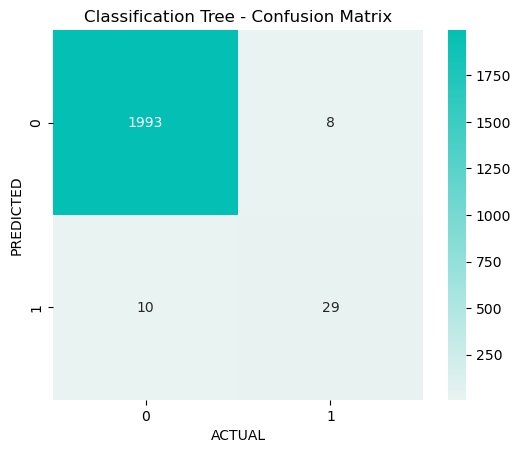

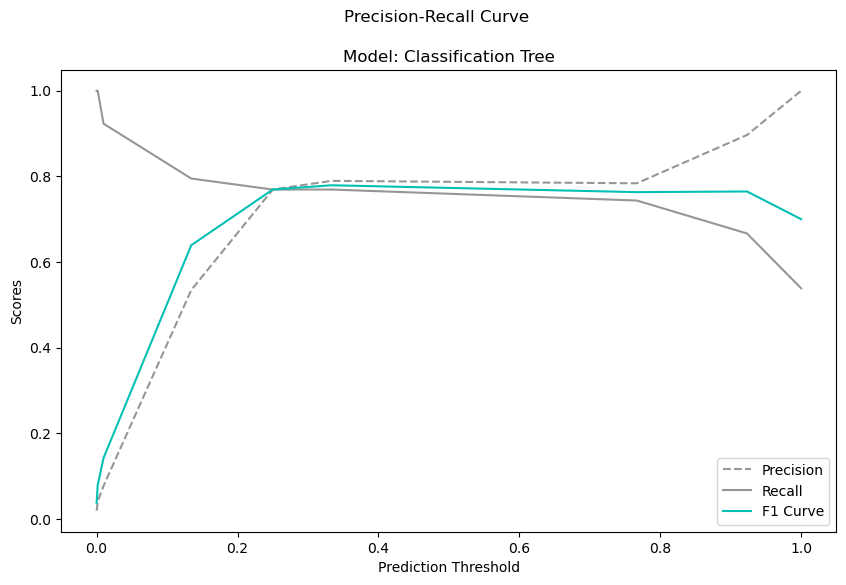

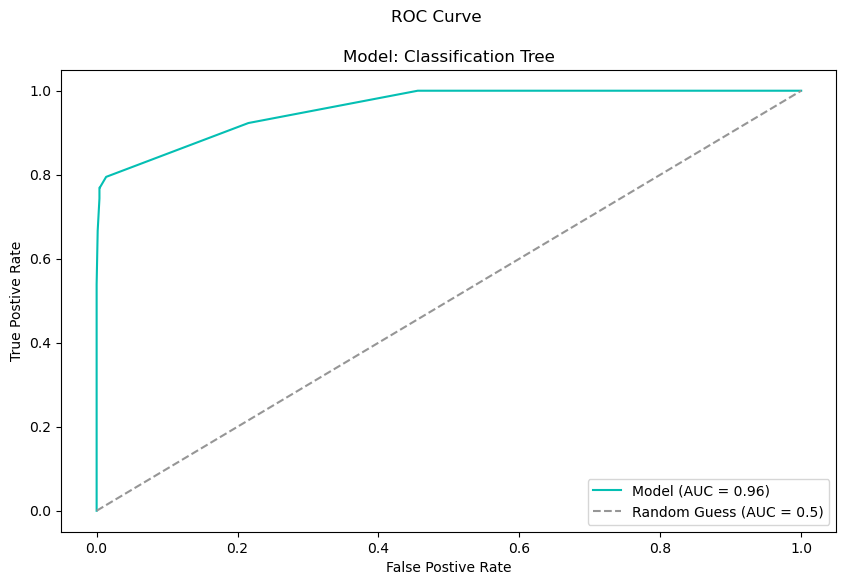

In [424]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y, test_size=0.2)
X_train, X_test = scale_data(X_train, X_test, True)

# Prepare and fit model
model_1 = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)
model_1_name = 'Classification Tree'

# Get predictions and probabilities
y_pred_1 = model_1.predict(X_test)
y_proba_1 = model_1.predict_proba(X_test)[:,1]

# Get model performance metrix
metrics_1, pr_curve_1, roc_param_1 = model_performance_metrics(y_test, y_proba_1, y_pred_1, model_1_name)
display(pd.DataFrame([metrics_1]))

# Compute and display confusion matrix
model_1_cm = confusion_matrix(y_test, y_pred_1)
show_confusion_matrix(model_1_cm, f'{model_1_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_1, model_1_name)

# ROC Curve
plot_roc_curve(roc_param_1, metrics_1, model_1_name)


### Feature importance (from classification tree)
When looking at the importance of the different features in this first model, it becomes clear that an 'Unknown' socio-economic status (SES) or employment type (Work) will have the greatere impact. This is in particular true for the SES=Unknown category which is a dominant feature.

When looking more into the reason behind this, it becomes clear that these 'Unknown' categories are unique to the shooters data and not present in the general population data. This will give a false indication to the model that these categories are a good indicator for the classification.

Different approaches can be taken to handle this problem:
1. Remove the features altogether and let the model work with the remaining categories.
2. Remove the rows where the feature appear. This will however significantly reduce the training dataset, which is already small, and leave uncertainty on the test dataset as these values cannot easily be imputed due to the proportion of missing data.
3. Finally, missing values could randomly be introduced into the general population dataset. This may however create artificial relationships between features as the mechanism behind these missing data are not known.

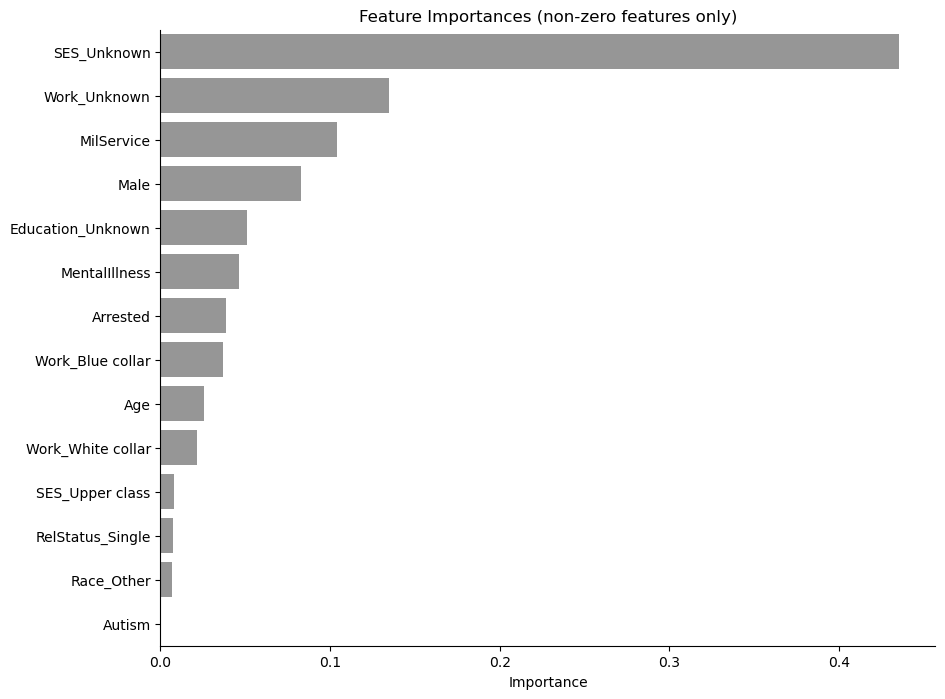

In [425]:
plot_feature_importances(model_1, X.columns)

In [407]:
shooters_df['SES'].value_counts()

Unknown         63
Middle class    62
Lower class     53
Upper class     19
Name: SES, dtype: int64

In [408]:
genpop_df['SES'].value_counts()

Middle class    4316
Lower class     2987
Upper class     2697
Name: SES, dtype: int64

In [409]:
shooters_df['Work'].value_counts()

Blue collar     125
Unknown          32
In between       23
White collar     17
Name: Work, dtype: int64

In [410]:
genpop_df['Work'].value_counts()

Blue collar     3767
White collar    3269
In between      2964
Name: Work, dtype: int64

### Remove 'Uknown' categories from SES and Work features
To address the problem of the dominance of shooter-specific values, we remove the `SES_Unknown` and `Work_Unknown` columns from the dataset before reapplying the model.

In [439]:
# Remove categrories that are unique to the shooter dataset and not present in the general population dataset
X_2 = X.drop(columns=['Work_Unknown', 'SES_Unknown', 'Education_Unknown', 'Male'])

,model,accuracy,precision,recall,f1_score,auc_score
0,Classification Tree,98.921569,81.481481,56.410256,66.666667,87.298018


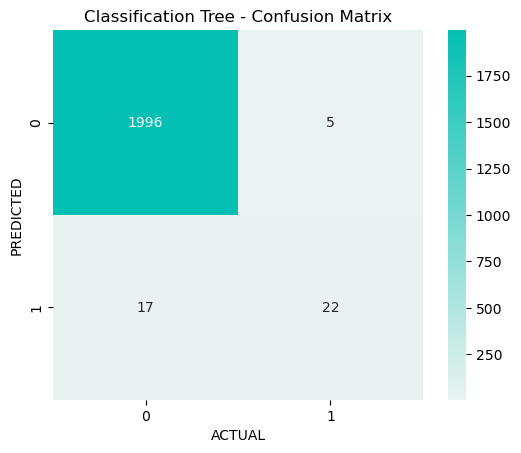

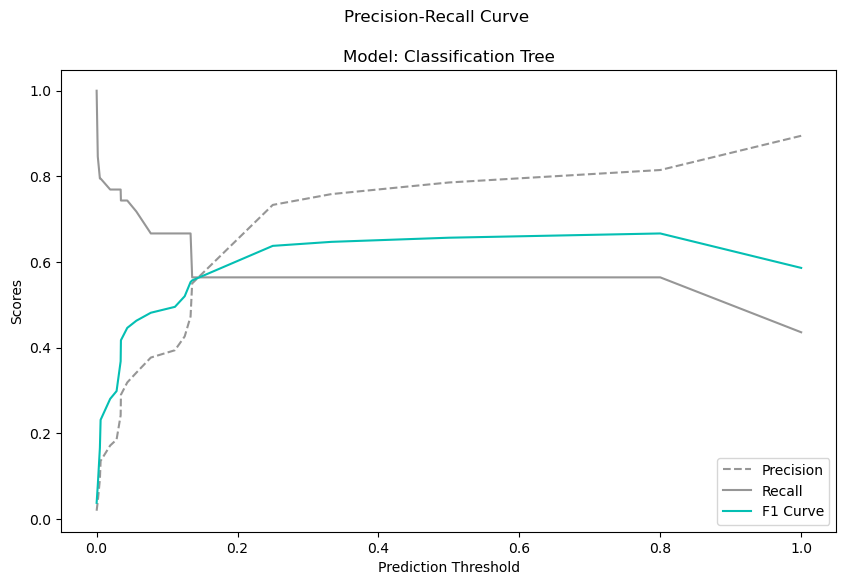

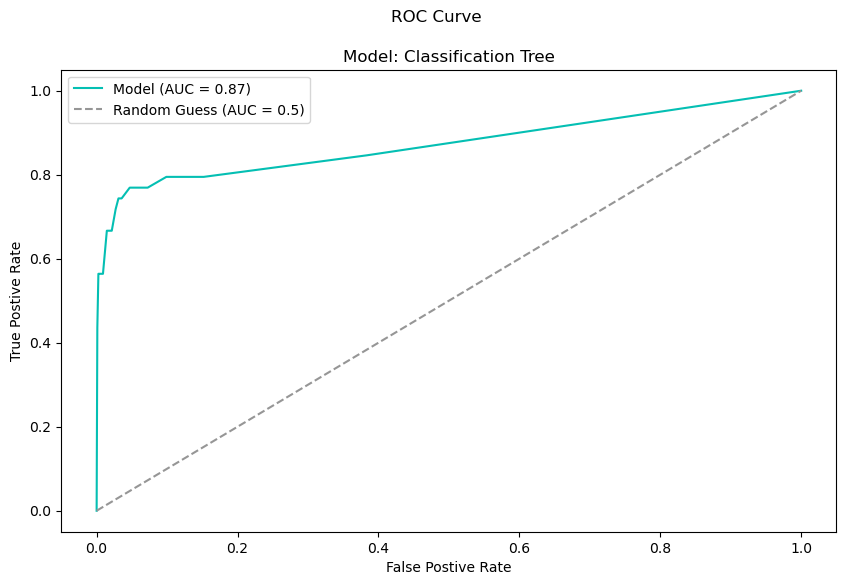

In [440]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X_2,y,random_state=1,stratify=y, test_size=0.2)
X_train, X_test = scale_data(X_train, X_test, True)

# Prepare and fit model
model_2 = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)
model_2_name = 'Classification Tree'

# Get predictions and probabilities
y_pred_2 = model_2.predict(X_test)
y_proba_2 = model_2.predict_proba(X_test)[:,1]

# Get model performance metrix
metrics_2, pr_curve_2, roc_param_2 = model_performance_metrics(y_test, y_proba_2, y_pred_2, model_2_name)
display(pd.DataFrame([metrics_2]))

# Compute and display confusion matrix
model_2_cm = confusion_matrix(y_test, y_pred_2)
show_confusion_matrix(model_2_cm, f'{model_2_name} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve_2, model_2_name)

# ROC Curve
plot_roc_curve(roc_param_2, metrics_2, model_2_name)


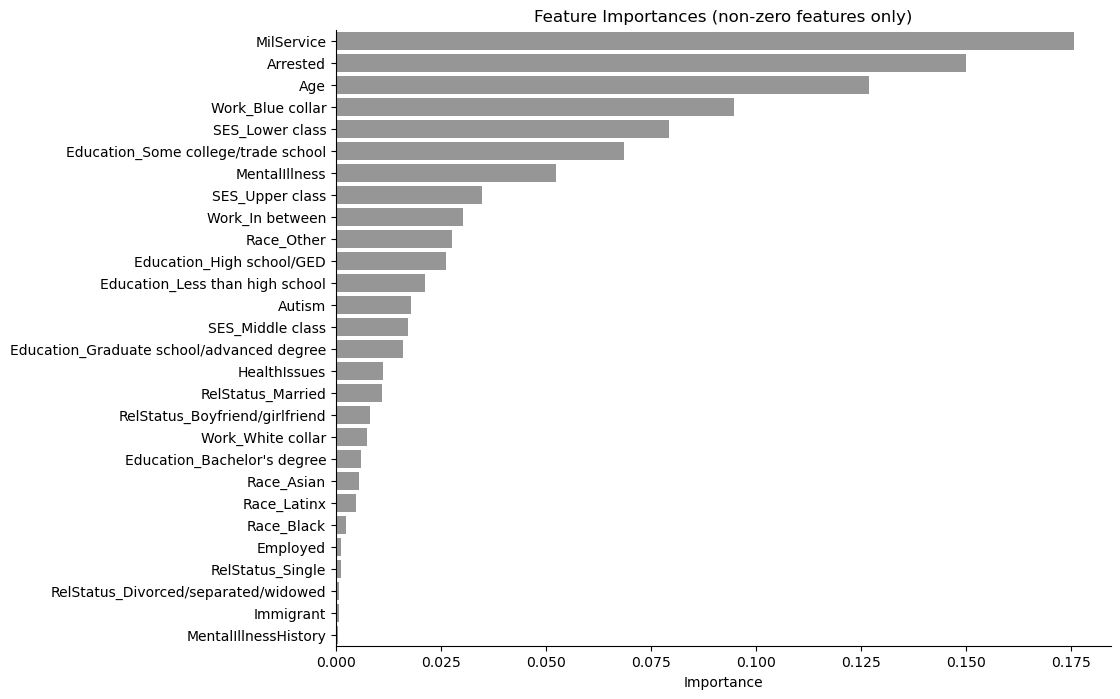

In [441]:
plot_feature_importances(model_2, X_2.columns)

## Comparison based on features used
By removing the important features that are unique to the shooters data but absent from the general population, the performance of the model drops in all metrics. It however remains acceptable, especially when compared to a random classifier (AUC = 87%). It is also important to remember that this is only a preliminary model that has not been tuned. These results are therefore encouraging and constitute a sane baseline to improve on.

In [443]:
metrics_overview = pd.DataFrame([metrics_1, metrics_2])

# Rename models for clarity
metrics_overview.loc[0, 'model'] = 'Class. Tree (all features)'
metrics_overview.loc[1, 'model'] = 'Class. Tree (limited features)'

metrics_overview

,model,accuracy,precision,recall,f1_score,auc_score
0,Class. Tree (all features),99.117647,78.378378,74.358974,76.315789,95.887313
1,Class. Tree (limited features),98.921569,81.481481,56.410256,66.666667,87.298018


## Resampling methods

In [15]:
import imblearn.over_sampling as OS

In [17]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

# Create Nx as many positive samples
N = 4
ratio = {1: n_pos*N, 0: n_neg}

# Randomly oversample
ROS = OS.RandomOverSampler(
	sampling_strategy = ratio,
	random_state = 42
)

X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

print(f"Original Pos Class Count: {np.sum(y_train)}")
print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

Original Pos Class Count: 154
Oversample Pos Class Count: 616
